In [1]:

import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from time import time 
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
tensorboard = TensorBoard(log_dir = "logs5/{}".format(time()))

In [3]:
features1 = pd.read_csv('CSV/features_combines.csv')

In [4]:
target = pd.read_csv('CSV/intel_stocks_2years.csv')

In [5]:
target.set_index('Date', inplace = True)

In [6]:
target.fillna(0, inplace = True)

In [7]:
#features1.set_index('Date', inplace = True).fillna(0, inplace = True)

AttributeError: 'NoneType' object has no attribute 'fillna'

In [8]:
features1.fillna(0, inplace = True)

In [9]:
#SUPPLY CHAIN ANALYSIS
#data split

train_data, test_data, train_targets, test_targets = train_test_split(features1, target, test_size = 0.2, random_state = 1)

In [10]:
#train and fit linear regression model

model_linear = LinearRegression(normalize=True)
model_linear.fit(train_data,train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [11]:
#predict from linear regresion model
y_predicted_linear = model_linear.predict(test_data)

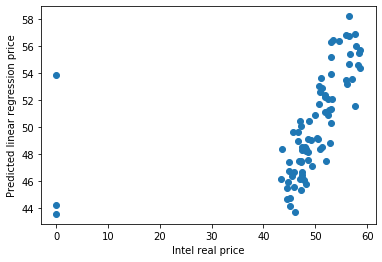

In [12]:
#plot real values vs predicted from linear model
plt.scatter(test_targets,y_predicted_linear)
plt.xlabel('Intel real price')
plt.ylabel('Predicted linear regression price')
plt.show()

In [13]:
#normalize data for deep learning

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [14]:
train_data.shape

(337, 21)

In [15]:
test_data.shape

(85, 21)

In [16]:
#turn dataframes into tensors

train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_targets = train_targets.to_numpy()

In [17]:
features_tensor = features1.to_numpy()
target_tensor = target.to_numpy()

In [18]:
#Define the Deep Learning model using the library Keras. Using 32 neurons per hidden layers, and using two of these.

from keras import models
from keras import layers 

def build_model():
    model_DeepLearning = models.Sequential()
    model_DeepLearning.add(layers.Dense(16, activation = 'relu',input_shape=(train_data.shape[1],)))
    model_DeepLearning.add(layers.Dense(3, activation = 'relu'))
    model_DeepLearning.add(layers.Dense(1))
    model_DeepLearning.compile(optimizer='rmsprop', loss='mse', metrics=['mae','acc'])
    return model_DeepLearning

In [19]:
#K-fold validation: Running the number of epochs k number of times, and then calculating the average of the loss values obteained at each time pass between 1 and k.

import numpy as np

k=4
num_val_samples = len(train_data) // k
all_scores = []

In [20]:
#Fit the model to the data first using a for loop for K-fold validation. Training the model on silent mode

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold#',i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    
    model_DeepLearning = build_model()
    history = model_DeepLearning.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,batch_size=1,verbose=1, callbacks=[tensorboard])
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold# 0
Train on 253 samples, validate on 84 samples
Epoch 1/500
253/253 [==============================] - 1s 3ms/step - loss: 2238.7561 - mae: 47.1388 - acc: 0.0000e+00 - val_loss: 1922.4794 - val_mae: 43.5232 - val_acc: 0.0000e+00
Epoch 2/500
253/253 [==============================] - 0s 1ms/step - loss: 1498.7533 - mae: 38.2601 - acc: 0.0000e+00 - val_loss: 967.9512 - val_mae: 30.2984 - val_acc: 0.0000e+00
Epoch 3/500
253/253 [==============================] - 0s 1ms/step - loss: 504.0660 - mae: 20.0037 - acc: 0.0000e+00 - val_loss: 215.0433 - val_mae: 12.7044 - val_acc: 0.0000e+00
Epoch 4/500
253/253 [==============================] - 0s 1ms/step - loss: 73.9077 - mae: 6.6896 - acc: 0.0000e+00 - val_loss: 74.4308 - val_mae: 5.9402 - val_acc: 0.0000e+00
Epoch 5/500
253/253 [==============================] - 0s 1ms/step - loss: 27.3760 - mae: 4.0534 - acc: 0.0000e+00 - val_loss: 47.4244 - val_mae: 4.0141 - val_acc: 0.0000e+00
Epoch 6/500
253/253 [=========================

In [21]:
#loss value

np.mean(all_mae_histories)

2.1632628284692763

In [22]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

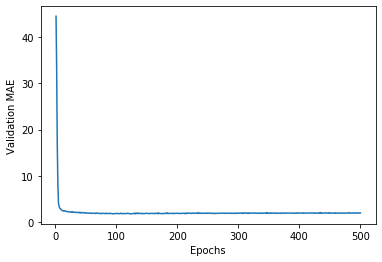

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

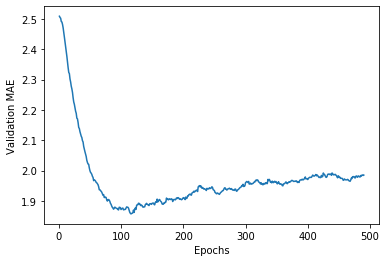

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_mae', 'val_acc', 'loss', 'mae', 'acc'])


dict_keys(['val_loss', 'val_mae', 'val_acc', 'loss', 'mae', 'acc'])


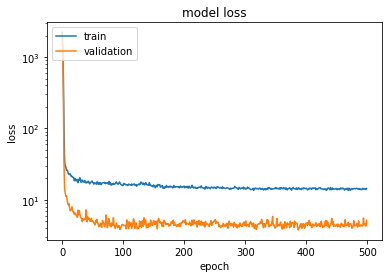

<Figure size 72x72 with 0 Axes>

In [26]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'validation'], loc='upper left')
plt.figure(figsize=(1,1))
plt.show()

In [27]:
mean = features_tensor.mean(axis=0)
features_tensor -= mean
std = features_tensor.std(axis=0)
features_tensor /= std

In [28]:
y_predict_DeepLearning = model_DeepLearning.predict(test_data)

In [29]:
y_predict_DeepLearning.shape

(85, 1)

In [30]:
predicted_values_DeepLearning_df = pd.DataFrame(y_predict_DeepLearning)
predicted_values_DeepLearning_df.rename(columns={0: 'Predicted Deep Learning'},inplace=True)

In [31]:
predicted_values_DeepLearning_df

,Predicted Deep Learning
0,57.280556
1,53.886345
2,46.457268
3,58.498348
4,44.960365
...,...
80,45.745602
81,46.713005
82,49.969933
83,47.300835


In [32]:
test_targets.reset_index(inplace=True)

In [33]:
test_targets

,Date,intel
0,10/31/19,57.599998
1,3/26/19,54.509998
2,10/29/18,0.000000
3,4/11/19,58.560001
4,10/16/18,45.939999
...,...,...
80,6/21/19,47.459999
81,1/10/19,48.130001
82,9/8/19,53.009998
83,1/1/19,47.439999


In [34]:
predicted_values_linear_df = pd.DataFrame(y_predicted_linear)
predicted_values_linear_df.rename(columns={0: 'Predicted Linear Regression'},inplace=True)

In [35]:
real_vs_predicted_df = pd.concat([test_targets, predicted_values_DeepLearning_df,predicted_values_linear_df], axis=1, join='inner')

In [36]:
real_vs_predicted_df

,Date,intel,Predicted Deep Learning,Predicted Linear Regression
0,10/31/19,57.599998,57.280556,56.895849
1,3/26/19,54.509998,53.886345,56.341479
2,10/29/18,0.000000,46.457268,43.569110
3,4/11/19,58.560001,58.498348,55.719117
4,10/16/18,45.939999,44.960365,46.673678
...,...,...,...,...
80,6/21/19,47.459999,45.745602,46.646436
81,1/10/19,48.130001,46.713005,48.375332
82,9/8/19,53.009998,49.969933,50.259030
83,1/1/19,47.439999,47.300835,48.510161


In [37]:
correl_complete = real_vs_predicted_df.corr().abs()

In [38]:
correl_complete

,intel,Predicted Deep Learning,Predicted Linear Regression
intel,1.000000,0.372198,0.470310
Predicted Deep Learning,0.372198,1.000000,0.878117
Predicted Linear Regression,0.470310,0.878117,1.000000


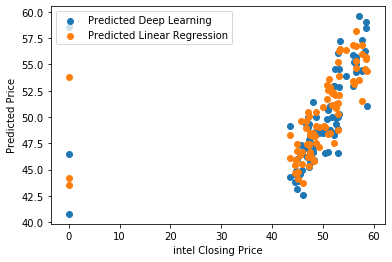

In [39]:
import matplotlib.pyplot as plt
plt.scatter(real_vs_predicted_df['intel'], real_vs_predicted_df['Predicted Deep Learning'])
plt.scatter(real_vs_predicted_df['intel'], real_vs_predicted_df['Predicted Linear Regression'])
plt.xlabel('intel Closing Price')
plt.ylabel('Predicted Price')
plt.legend(['Predicted Deep Learning', 'Predicted Linear Regression'], loc='upper left')
plt.show()